# NLP - Stance Detection for the Fake News Challenge

### Stance Detection for the Fake News Challenge for identifying textual relationships using LSTM Sequence to Sequence Encoder-Decoder model approach with attention layer


### Context

Fake News can be detected by applying stance classification, i.e. by classifying the stance of the body text relative to the claim made in the headline into one of the four categories 
1. Agrees: body text agrees with the headline 
2. Disagrees: body text disagrees with the headline 
3. Discusses: body text discusses the same topic as the headline, but does not take position 
4. Unrelated: body text discusses a different topic than the headline 

### Solution Approach

1. Use Glove embeddings and natural language toolkit 'punkt' 
2. Tokenizing the body text and headings through appropriate data structure hierarchy 
3. Pre-processing - One-Hot encoding, shuffle the data and split into train, test and validation sets 
4. Apply pre-trained Glove word embeddings for each token and Create embedding matrix 
5. Reshaping train datasets for compatibility with the Models
6. Define Sequence to Sequence Encoder Decoder LSTM Model
7. Compile, fit and note accuracy 
8. Build the same model with attention layers included for better performance
9. Compile, fit and note accuracy for attention model 
10. Compare Sequence to Sequence Encoder-Decoder LSTM model - with and without Attention layers


## Load datasets and dependencies  



### Mount the google drive to access required project files

Run the below commands

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Path for Project files on google drive


In [0]:
project_path = "/content/drive/My Drive/Fake News Challenge/"

### Loading the Glove Embeddings

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'glove.6B.zip', 'r') as z:
  z.extractall()

## Import Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Activation, Dot, Reshape, Flatten 
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


### Load the dataset 

1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given train datasets files **`train_bodies.csv`** and **`train_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`dataset`**.

In [5]:
train_bodies = pd.read_csv(project_path+'train_bodies.csv')
train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [6]:
train_stances = pd.read_csv(project_path+'train_stances.csv')
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [7]:
# Merge datasets using inner join on common field "Body ID" 
dataset = pd.merge(left=train_bodies, right=train_stances, left_on='Body ID', right_on='Body ID')
dataset.head(500)

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
495,23,In a sprawling Facebook post and subsequent in...,Staff Reporter,unrelated
496,23,In a sprawling Facebook post and subsequent in...,Crank-Boosting Behind Top Apps in App Store,unrelated
497,23,In a sprawling Facebook post and subsequent in...,China App Store Manipulation Photo Goes Viral ...,unrelated
498,23,In a sprawling Facebook post and subsequent in...,Chugging eggnog sends Utah man to hospital,unrelated


## Step2: Data Pre-processing and setting some hyper parameters needed for model


#### Run the code given below to set the required parameters.

1. `MAX_SENTS` = Maximum no.of sentences to consider in an article.

2. `MAX_SENT_LENGTH` = Maximum no.of words to consider in a sentence.

3. `MAX_NB_WORDS` = Maximum no.of words in the total vocabualry.

4. `MAX_SENTS_HEADING` = Maximum no.of sentences to consider in a heading of an article.

In [0]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

### Tokenizing the text 

Keras provides [Tokenizer API](https://keras.io/preprocessing/text/) for preparing text. Read it before going any further.

#### Import the Tokenizer from keras preprocessing text

#### Initialize the Tokenizer class with maximum vocabulary count as `MAX_NB_WORDS` initialized at the start of step2. 

In [0]:
t = Tokenizer(num_words=MAX_NB_WORDS)

#### Now, using fit_on_texts() from Tokenizer class, lets encode the data 

Note: We need to fit articleBody and Headline also to cover all the words.

In [0]:
t.fit_on_texts(dataset['articleBody'])
t.fit_on_texts(dataset['Headline'])

In [11]:
# Get vocabulary size for future use 
vocab_size = len(t.word_index.items())
vocab_size

27873

In [12]:
# Check sample word index 
print(t.word_index['perhaps'])

954


#### fit_on_texts() gives the following attributes in the output as given [here](https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/).

* **word_counts:** dictionary mapping words (str) to the number of times they appeared on during fit. Only set after fit_on_texts was called.

* **word_docs:** dictionary mapping words (str) to the number of documents/texts they appeared on during fit. Only set after fit_on_texts was called.

* **word_index:** dictionary mapping words (str) to their rank/index (int). Only set after fit_on_texts was called.

* **document_count:** int. Number of documents (texts/sequences) the tokenizer was trained on. Only set after fit_on_texts or fit_on_sequences was called.



### Now, tokenize the sentences using nltk sent_tokenize() and encode the senteces with the ids we got form the above `t.word_index`

Initialise 2 lists with names `texts` and `articles`.

```
texts = [] to store text of article as it is.

articles = [] split the above text into a list of sentences.
```

In [13]:
# Populate texts
texts = dataset['articleBody']
texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [0]:
# Initialize articles list
articles = ['' for i in range(len(texts))]

# initialize 2d list for article sentences, which will be required to limit to 20 words per sentence
rows = len(texts)
cols = MAX_SENTS
articles_sent = [ ([''] * cols) for row in range(rows) ] # initialize 2d list

In [0]:
# Populate sentences 
for i in range(len(texts)):
  articles[i] = sent_tokenize(texts[i])
  j=0
  for sentence in articles[i]:
    articles_sent[i][j] = sentence
    j = j+1
    if j == 20: break


In [16]:
# Check sample sentence, to see if it has been loaded properly till the end 
articles_sent[49971][4]

'The realtors said they wanted to do something special for someone in the service industry.'

In [17]:
articles[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

### Now iterate through each article and each sentence to encode the words into ids using t.word_index 

Here, to get words from sentence you can use `text_to_word_sequence` from keras preprocessing text.

1. Import text_to_word_sequence

2. Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name `data` with zeros first (you can use numpy [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) to initialize with all zeros)and then update it while iterating through the words and sentences in each article.

In [18]:
# Initialize data 
data = np.zeros((len(articles), MAX_SENTS, MAX_SENT_LENGTH), dtype=int)
data.shape

(49972, 20, 20)

In [0]:
# Populate 3d array - iterating through the words in each sentence, and sentences in each article.
i=0
j=0
k=0

for i in range(len(articles)):
  for j in range(len(articles_sent[i])):
    result = text_to_word_sequence(''.join(articles_sent[i][j]))
    if j==19: break
    for k in range(len(result)):
        data[i][j][k] = t.word_index[result[k]]
        if k==19: break


In [20]:
data[0, :, :]

array([[    3,   481,   427,  7211,    81,     3,  3733,   331,     5,
         3891,   350,     4,  1431,  2958,     1,    89,    12,   464,
            0,     0],
       [  758,    95,  1047,     3,  2679,  1752,     7,   189,     3,
         1217,  1075,  2030,   700,   159,     1,  3032,   448,     1,
          555,   235],
       [   89,  1067,  4115,  2349,    12,     3,  1092,  3306,    19,
            1,    89,     2,  1793,     1,   521,  2009,    15,     9,
            3,  3111],
       [  181,  3640,   972,   200,  2556,    44,  6775,  1722,  1252,
            5, 13317, 17936,     1,   778,    31,   740,  3990,    67,
           85,     0],
       [ 2349,    12,  1557,    38,  1094,   351,   775,     2,   367,
          260,  1770,     5,  4450,    70,   494,     0,     0,     0,
            0,     0],
       [    1,   700,   189,    19,     1,   427,    32,     3,  7417,
            4,  2159,  1252,     6,     3,  5270,     4,  1217,  1252,
           12,  3363],
       [  

### Repeat the same process for the `Headings` as well. Use variables with names `texts_heading` and `articles_heading` accordingly

In [21]:
# Populate text heading
texts_heading = dataset['Headline']
texts_heading[0]

'Soldier shot, Parliament locked down after gunfire erupts at war memorial'

In [0]:
# Initialize heading array 
articles_heading = ['' for i in range(len(texts_heading))]

# initialize 2d list for heading sentences
rows = len(texts)
cols = MAX_SENTS_HEADING
articles_heading_sent = [ ([''] * cols) for row in range(rows) ] # initialize 2d list

In [0]:
# Separate heading sentences 
for i in range(len(texts_heading)):
  articles_heading[i] = sent_tokenize(texts_heading[i])
  j=0  
  for sentence in articles_heading[i]:
    articles_heading_sent[i][j] = sentence

In [24]:
# Check if heading sentence populated correctly 
articles_heading_sent[49971][0]

'Ann Arbor pizza delivery driver surprised with $2,000 tip'

In [25]:
# Initialize data heading 
data_heading = np.zeros((len(articles_heading), MAX_SENTS_HEADING, MAX_SENT_LENGTH), dtype=int)
data_heading.shape

(49972, 1, 20)

In [0]:
# Populate 3d array - iterating through the words in each sentence, and sentences in each heading.
i=0
j=0
k=0
for i in range(len(articles_heading)):
  for j in range(len(articles_heading_sent[i])):
    result = text_to_word_sequence(''.join(articles_heading_sent[i][j]))
    for k in range(len(result)):
      data_heading[i][j][k] = t.word_index[result[k]]
      if k==19: break

In [27]:
data_heading[0, :, :]

array([[  718,   206,   343,  7134,   193,    34,  1338, 11554,    21,
          233,   686,     0,     0,     0,     0,     0,     0,     0,
            0,     0]])

### Now the features are ready, lets make the labels ready for the model to process.

### Convert labels into one-hot vectors

You can use [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in pandas to create one-hot vectors.

In [28]:
# Load stance data from main dataset 
stance = dataset['Stance']
stance[499]

'agree'

In [0]:
# Populate labels as array 
labels = np.asarray(pd.get_dummies(stance))

In [30]:
# Check shapes of data, data heading and labels arrays 
print('Shape of data tensor:', data.shape)
print('Shape of data heading tensor:', data_heading.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 20, 20)
Shape of data heading tensor: (49972, 1, 20)
Shape of label tensor: (49972, 4)


In [31]:
# Check one sample one-hot encoded label 
print(labels[499][:])

[1 0 0 0]


### Shuffle the data

In [0]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [0]:
## shuffle the data
data = data[indices]
data_heading = data_heading[indices]
## shuffle the labels according to data
labels = labels[indices]

### Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.


Use the variable names as given below:

x_train, x_val - for body of articles.

x-heading_train, x_heading_val - for heading of articles.

y_train - for training labels.

y_val - for validation labels.



In [0]:
# Split in train and test for articles as well as headings data, using same random state 
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=21)
x_heading_train, x_heading_val, y_train, y_val  = train_test_split(data_heading, labels, test_size=0.2, random_state=21)

In [35]:
# Check shapes of all train and test arrays 
print(x_train.shape)
print(x_heading_train.shape)
print(y_train.shape)

print(x_val.shape)
print(x_heading_val.shape)
print(y_val.shape)

(39977, 20, 20)
(39977, 1, 20)
(39977, 4)
(9995, 20, 20)
(9995, 1, 20)
(9995, 4)


###  Load the pre-trained Glove word embeddings for each token and Create embedding matrix with the glove embeddings


In [36]:
# Load the whole embedding into memory

embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# Create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 100))

for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [37]:
# Check length of embedding matrix, should be equal to vocabulary size 
len(embedding_matrix)

27873

### Sequence to Sequence Encoder-Decoder model approach and report accuracy score

### Reshape train datasets for compatibility with the Models

In [0]:
x_train_resh = x_train.reshape(39977, 400)
x_val_resh = x_val.reshape(9995, 400)

In [0]:
x_heading_train_resh = x_heading_train.reshape(39977, 20)
x_heading_val_resh = x_heading_val.reshape(9995, 20)

In [40]:
# Check shapes after resizing 
print(x_train_resh.shape)
print(x_heading_train_resh.shape)
print(y_train.shape)

print(x_val_resh.shape)
print(x_heading_val_resh.shape)
print(y_val.shape)

(39977, 400)
(39977, 20)
(39977, 4)
(9995, 400)
(9995, 20)
(9995, 4)


### Define Sequence to Sequence Encoder Decoder LSTM Model










Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 100)     2787300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)      2787300     input_2[0][0]                    
___________________________________________________________________________________

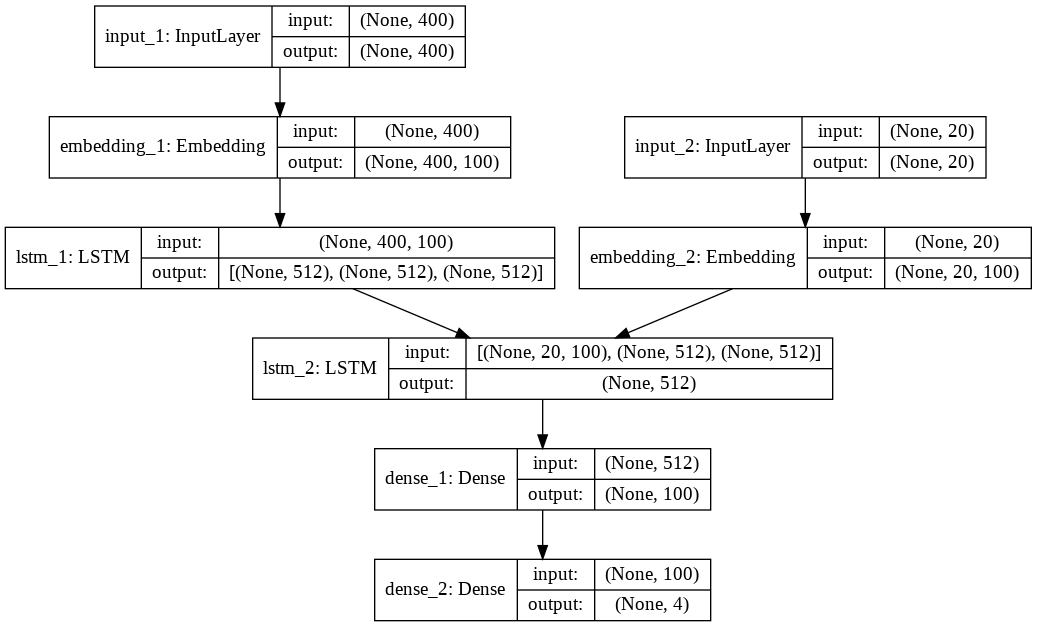

In [41]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(400,))
x = Embedding(vocab_size, 100, weights=[embedding_matrix], 
              trainable=False)(encoder_inputs)
x, state_h, state_c = LSTM(units=512,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(20,))
x = Embedding(vocab_size, 100, weights=[embedding_matrix], 
              trainable=False)(decoder_inputs)
x = LSTM(units=512, return_sequences=False)(x, initial_state=encoder_states)
x = Dense(100, input_shape=(512,), activation='relu')(x)
decoder_outputs = Dense(4, activation='softmax')(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# plot the model
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)


### Compile and fit the model

In [42]:
# Compile the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the Seq to Seq Encoder Decoder LSTM model and check accuracy on validation set 
%%time
model.fit(x=[x_train_resh, x_heading_train_resh],
          y=y_train,
          batch_size=64,
          epochs=40,
          validation_data=([x_val_resh, x_heading_val_resh],y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 39977 samples, validate on 9995 samples
Epoch 1/40
39977/39977 [==============================] - 376s 9ms/step - loss: 0.8007 - acc: 0.7279 - val_loss: 0.8001 - val_acc: 0.7354
Epoch 2/40
39977/39977 [==============================] - 357s 9ms/step - loss: 0.7672 - acc: 0.7305 - val_loss: 0.7568 - val_acc: 0.7369
Epoch 3/40
39977/39977 [==============================] - 354s 9ms/step - loss: 0.7239 - acc: 0.7329 - val_loss: 0.6550 - val_acc: 0.7491
Epoch 4/40
39977/39977 [==============================] - 353s 9ms/step - loss: 0.6955 - acc: 0.7394 - val_loss: 0.7551 - val_acc: 0.7354
Epoch 5/40
39977/39977 [==============================] - 351s 9ms/step - loss: 0.6808 - acc: 0.7361 - val_loss: 0.7481 - val_acc: 0.7354
Epoch 6/40
39977/39977 [==============================] - 352s 9ms/step - loss: 0.6539 - acc: 0.7427 - val_loss: 0.5644 - val_acc: 0.7651
Epoch 7/40
39977/39977 [===

In [45]:
# Generate predicted output 
yhat = model.predict([x_val_resh, x_heading_val_resh], verbose=1)


9995/9995 [==============================] - 63s 6ms/step


In [53]:
# Check predictions with actual validation data for 10 random samples 
for i in range(10):
  a = (random.randint(1,9995))
  print("Index",a) 
  print("Predicted:",yhat[a][:])
  print("Actual:",y_val[a][:])


Index 1249
Predicted: [0.0000000e+00 0.0000000e+00 1.3386184e-29 1.0000000e+00]
Actual: [0 0 0 1]
Index 2238
Predicted: [3.0957772e-38 0.0000000e+00 9.0108394e-24 1.0000000e+00]
Actual: [0 0 0 1]
Index 8175
Predicted: [0.0000000e+00 0.0000000e+00 2.1377309e-33 1.0000000e+00]
Actual: [0 0 0 1]
Index 5694
Predicted: [7.5171415e-06 7.3199773e-17 8.0914710e-08 9.9999237e-01]
Actual: [0 0 0 1]
Index 5183
Predicted: [8.4148563e-27 1.1244908e-34 2.1080897e-20 1.0000000e+00]
Actual: [0 0 0 1]
Index 1192
Predicted: [9.9999380e-01 1.3140769e-06 1.8136924e-06 3.0572123e-06]
Actual: [1 0 0 0]
Index 965
Predicted: [2.4695628e-06 1.1091984e-17 9.5094812e-01 4.9049374e-02]
Actual: [0 0 1 0]
Index 8279
Predicted: [4.9688029e-32 0.0000000e+00 1.1532414e-18 1.0000000e+00]
Actual: [0 0 0 1]
Index 7968
Predicted: [9.9999952e-01 3.3151457e-14 2.1934017e-07 2.1477058e-07]
Actual: [1 0 0 0]
Index 6950
Predicted: [9.9997008e-01 3.0676545e-11 9.8474147e-06 2.0089548e-05]
Actual: [1 0 0 0]


## Build the same model with attention layers included for better performance (Optional)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 400, 100)     2787300     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 100)      2787300     input_4[0][0]                    
____________________________________________________________________________________________

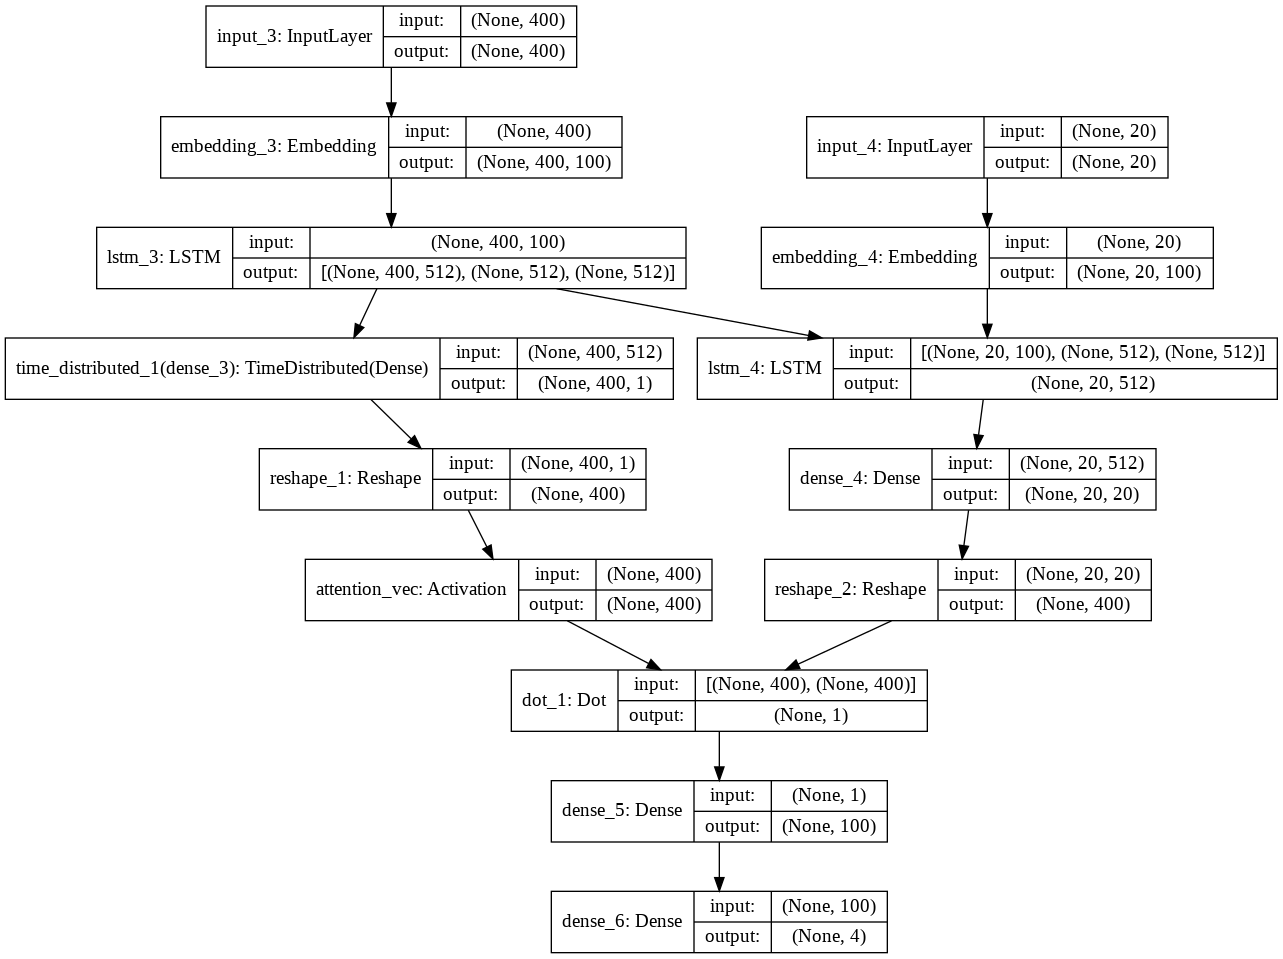

In [54]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(400,))
enc = Embedding(vocab_size, 100, weights=[embedding_matrix], 
              trainable=False)(encoder_inputs)
enc, state_h, state_c = LSTM(units=512, return_sequences=True,
                           return_state=True)(enc)
encoder_states = [state_h, state_c]

# Defining Attention vectors 
att_vector = TimeDistributed(Dense(1,input_shape=(512,)))(enc)
att_vector_res = Reshape([400])(att_vector)
att_vector_res = Activation('softmax', name='attention_vec')(att_vector_res)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(20,))
dec = Embedding(vocab_size, 100, weights=[embedding_matrix], 
              trainable=False)(decoder_inputs)
dec = LSTM(units=512, return_sequences=True)(dec, initial_state=encoder_states)
dec = Dense(20)(dec)
dec_res = Reshape([400])(dec)

# Merging through dot product 
att_output = Dot(axes=1)([dec_res, att_vector_res])

dec_res = Dense(100, input_shape=(1,), activation='relu')(att_output)
decoder_outputs = Dense(4, activation='softmax')(dec_res)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model_att = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# plot the model
model_att.summary()
plot_model(model_att, to_file='model_att.png', show_shapes=True)

In [0]:
# Compile the model 
model_att.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model and report the accuracy score for the model with attention layer (Optional)

In [56]:
# Train the Seq to Seq Encoder Decoder LSTM model with Attention layer and check accuracy on validation set 
%%time
model_att.fit(x=[x_train_resh, x_heading_train_resh],
          y=y_train,
          batch_size=64,
          epochs=40,
          validation_data=([x_val_resh, x_heading_val_resh],y_val))

Train on 39977 samples, validate on 9995 samples
Epoch 1/40
39977/39977 [==============================] - 379s 9ms/step - loss: 0.7836 - acc: 0.7302 - val_loss: 0.7370 - val_acc: 0.7461
Epoch 2/40
39977/39977 [==============================] - 374s 9ms/step - loss: 0.6983 - acc: 0.7591 - val_loss: 0.6595 - val_acc: 0.7727
Epoch 3/40
39977/39977 [==============================] - 373s 9ms/step - loss: 0.6343 - acc: 0.7819 - val_loss: 0.6247 - val_acc: 0.7843
Epoch 4/40
39977/39977 [==============================] - 373s 9ms/step - loss: 0.5755 - acc: 0.8000 - val_loss: 0.5868 - val_acc: 0.8016
Epoch 5/40
39977/39977 [==============================] - 372s 9ms/step - loss: 0.5192 - acc: 0.8140 - val_loss: 0.5244 - val_acc: 0.8125
Epoch 6/40
39977/39977 [==============================] - 373s 9ms/step - loss: 0.4758 - acc: 0.8286 - val_loss: 0.4943 - val_acc: 0.8235
Epoch 7/40
39977/39977 [==============================] - 375s 9ms/step - loss: 0.4350 - acc: 0.8386 - val_loss: 0.4635 - v

In [57]:
# Generate predicted output 
yhat_att = model_att.predict([x_val_resh, x_heading_val_resh], verbose=1)

9995/9995 [==============================] - 67s 7ms/step


In [59]:
# Check predictions with actual validation data for 10 random samples 
for i in range(10):
  a = (random.randint(1,9995))
  print("Index",a)
  print("Predicted:",yhat_att[a][:])
  print("Actual:",y_val[a][:])

Index 596
Predicted: [5.6911780e-17 0.0000000e+00 4.7281375e-08 1.0000000e+00]
Actual: [0 0 0 1]
Index 2686
Predicted: [3.6118969e-10 3.6295660e-08 9.9993634e-01 6.3610321e-05]
Actual: [0 0 1 0]
Index 2266
Predicted: [3.4049337e-04 3.7167855e-03 9.8506343e-01 1.0879284e-02]
Actual: [1 0 0 0]
Index 3567
Predicted: [1.0897549e-11 3.3209590e-28 1.1486434e-05 9.9998856e-01]
Actual: [0 0 0 1]
Index 2253
Predicted: [2.2768103e-02 7.0607193e-08 1.4158806e-01 8.3564383e-01]
Actual: [0 0 0 1]
Index 2392
Predicted: [1.4469649e-01 5.0449557e-06 2.6020527e-01 5.9509319e-01]
Actual: [0 0 0 1]
Index 7669
Predicted: [1.1359609e-16 0.0000000e+00 6.4602062e-08 9.9999988e-01]
Actual: [0 0 0 1]
Index 4805
Predicted: [2.1507395e-15 2.5557835e-36 2.4381700e-07 9.9999976e-01]
Actual: [0 0 0 1]
Index 6456
Predicted: [0.92320764 0.01652148 0.04468791 0.01558302]
Actual: [1 0 0 0]
Index 8006
Predicted: [2.0161597e-08 4.7523913e-21 3.4326271e-04 9.9965680e-01]
Actual: [0 0 0 1]


## Comparing Sequence to Sequence Encoder-Decoder LSTM model - with and without Attention layers

1. Without Attention: Reached Validation Accuracy of 96.06% after 40 epochs. 
2. With Attention: Reached Validation Accuracy of 91.13% after 40 epochs. 
3. Without Attention: Obtained lower Validation Accuracy in inital epochs - 80.63% after 8 epochs. 
4. With Attention: Obtained higher Validation Accuracy in inital epochs - 83.49% after 8 epochs.
5. There is a scope to improve Attention layer model further. 
6. Overall accuracy can also be increased by using GLOVE embeddings of 200 or 300 dimensions and by increasing vocabulary size. 